## n-Armed Bandits

This sample introduces the n-armed bandit problem, the conflict between exploration and exploitation, and several ways how to balance this conflict.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

### The Problem defintion:
A typical slot machine is a device in which the player pulls a lever arm and receives rewards at some expected rate. Because the expected rate is typically negative, these machines are sometimes referred to as “one-armed bandits”. By analogy, a “multi-armed bandit” is a machine in which there are multiple lever arms to pull, each one of which may pay out at a different expected rate (= reward). 

The “multi-armed bandit” problem refers to the challenge of constructing a strategy for pulling the levers when one has no prior knowledge of the payout rate for any of the levers. Therefore, one must strike a balance between exploring each of the levers in order to determine their value, while exploiting one’s current knowledge in order to favor high paying levers.

### The Bandit Class
Let's define the bandit:

In [2]:
class Bandit:
    def __init__(self, k):
        # k: number of bandit arms
        self.k = k
        
        # qstar: action values
        self.qstar = np.random.normal(size=k).round(2)
    
    def action(self, a):
        return np.random.normal(loc=self.qstar[a])
    
    def __str__(self):
        return np.array_str(self.qstar)

print(Bandit(10))

[ 0.26 -0.16 -1.34 -0.95 -0.82  0.8  -0.16 -0.3  -0.33 -0.72]


The greed action selection algorithm

In [9]:
def greedy_action_selection(k, numsteps):
    # k: number of bandit arms
    # numsteps: number of steps (repeated action selections)
    
    # Apossible[t]: list of possible actions at step t
    Apossible = {}
    
    # A[t]: action selected at step t
    A = np.zeros((numsteps,))
    
    # N[a,t]: the number of times action a was selected 
    #         in steps 0 through t-1
    N = np.zeros((k,numsteps+1))
    
    # R[t]: reward at step t
    R = np.zeros((numsteps,))
    
    # Q[a,t]: estimated value of action a at step t
    Q = np.zeros((k,(numsteps+1)))

    # Initialize bandit
    bandit = Bandit(k)

    for t in range(numsteps):

        # Select greedy actions as possible actions
        Apossible[t] = np.argwhere(Q[:,t] == np.amax(Q[:,t])).flatten()

        # Select action randomly from possible actions
        a = Apossible[t][np.random.randint(len(Apossible[t]))]

        # Record action taken
        A[t] = a

        # Perform action (= sample reward)
        R[t] = bandit.action(a)

        # Update action counts
        N[:,t+1] = N[:,t]
        N[a,t+1] += 1

        # Update action value estimates, incrementally
        if N[a,t] > 0:
            Q[:,t+1] = Q[:,t]
            Q[a,t+1] = Q[a,t] + (R[t] - Q[a,t]) / N[a,t+1]
        else:
            Q[:,t+1] = Q[:,t]
            Q[a,t+1] = R[t]

        #Q[:,t] = np.around(Q:t], decimals=2)
    return {'bandit': bandit, 
            'Apossible': Apossible, 
            'A': A, 'N' : N, 'R' : R, 'Q' : Q}

### Single run

In [10]:
k = 10
numsteps = 5

bandit_task = greedy_action_selection(k, numsteps)

print('Bandit Q: %s' % bandit_task['bandit'])
print('Action a: %s' % bandit_task['A'])
print('Reward r: %s' % bandit_task['R'])
print('Est    Q:')
print('%s' %bandit_task['Q'])

Bandit Q: [ 0.62 -0.29  0.31 -0.28  0.5  -0.64  0.69  0.11 -1.52  0.45]
Action a: [3. 5. 7. 7. 7.]
Reward r: [-0.64902403 -0.43654141  0.68166484  1.46721182  1.17539909]
Est    Q:
[[ 0.          0.          0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.        ]
 [ 0.         -0.64902403 -0.64902403 -0.64902403 -0.64902403 -0.64902403]
 [ 0.          0.          0.          0.          0.          0.        ]
 [ 0.          0.         -0.43654141 -0.43654141 -0.43654141 -0.43654141]
 [ 0.          0.          0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.68166484  1.07443833  1.10809192]
 [ 0.          0.          0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.        ]]


### Conversation over 500 plays

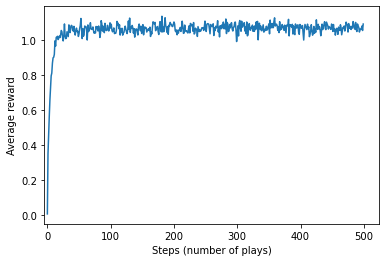

In [5]:
k = 10
numsteps = 500
numtasks = 2000

avgR = np.zeros((numsteps, ))
for task in range(numtasks):
    bandit_task = greedy_action_selection(k,numsteps)
    avgR += bandit_task['R']
avgR /= numtasks

plt.plot(avgR) ;
plt.ylabel('Average reward') ;
plt.xlabel('Steps (number of plays)') ;
plt.xlim(-5) ;

## $\varepsilon$-greedy action selection

In [6]:
def epsilon_greedy_action_selection(k, numsteps, epsilon):
    # k: number of bandit arms
    # numsteps: number of steps (repeated action selections)
    # epsilon: probability with which a random action is selected,
    #          as opposed to a greedy action

    # Apossible[t]: list of possible actions at step t
    Apossible = {}
    
    # A[t]: action selected at step t
    A = np.zeros((numsteps,))
    
    # N[a,t]: the number of times action a was selected 
    #         in steps 0 through t-1
    N = np.zeros((k,numsteps+1))
    
    # R[t]: reward at step t
    R = np.zeros((numsteps,))
    
    # Q[a,t]: estimated value of action a at step t
    Q = np.zeros((k,(numsteps+1)))

    # Initialize bandit
    bandit = Bandit(k)

    for t in range(numsteps):
        if np.random.rand() < epsilon:
            # All actions are equally possible
            Apossible[t] = np.arange(k)
        else:
            # Select greedy actions as possible actions
            Apossible[t] = np.argwhere(Q[:,t] == np.amax(Q[:,t])).flatten()

        # Select action randomly from possible actions
        a = Apossible[t][np.random.randint(len(Apossible[t]))]

        # Record action taken
        A[t] = a

        # Perform action (= sample reward)
        R[t] = bandit.action(a)

        # Update action counts
        N[:,t+1] = N[:,t]
        N[a,t+1] += 1

        # Update action value estimates, incrementally
        if N[a,t] > 0:
            Q[:,t+1] = Q[:,t]
            Q[a,t+1] = Q[a,t] + (R[t] - Q[a,t]) / N[a,t]
        else:
            Q[:,t+1] = Q[:,t]
            Q[a,t+1] = R[t]

    return {'bandit' : bandit,
            'numsteps' : numsteps,
            'epsilon' : epsilon,
            'Apossible': Apossible, 
            'A': A, 'N' : N, 'R' : R, 'Q' : Q}

Comparisons of average reward with different $\varepsilon$ values

In [7]:
k = 10
numsteps = 500
numtasks = 2000
epsilon_a = 0.01
epsilon_b = 0.1

avgR_a = np.zeros((numsteps, ))

for task in range(2000):
    bandit_task = epsilon_greedy_action_selection(k,numsteps, epsilon_a)
    avgR_a += bandit_task['R']
avgR_a /= numtasks

avgR_b = np.zeros((numsteps, ))
for task in range(2000):
    bandit_task = epsilon_greedy_action_selection(k,numsteps, epsilon_b)
    avgR_b += bandit_task['R']
avgR_b /= numtasks

Let's print it for comparison

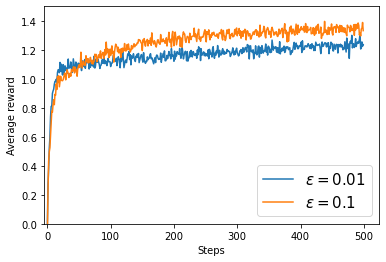

In [8]:
plt.plot(avgR_a, label=r'$\varepsilon = '+ str(epsilon_a) + '$') ;
plt.plot(avgR_b, label=r'$\varepsilon = '+ str(epsilon_b) + '$') ;
plt.ylabel('Average reward') ;
plt.xlabel('Steps') ;
plt.xlim(-5) ;
plt.ylim([0,1.5])
plt.legend(loc='lower right', fontsize=15) ;